# **Setting**

In [1]:
import os
import tensorflow as tf

print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.10.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# system
import os
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

# dataframe
import pickle
import numpy as np
import pandas as pd

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
# import koreanize_matplotlib

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# **1. 데이터 불러오기**

In [51]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

print(f'X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, X_train={y_test.shape}')

X_train=(50000, 32, 32, 3), y_train=(50000,), X_test=(10000, 32, 32, 3), X_train=(10000,)


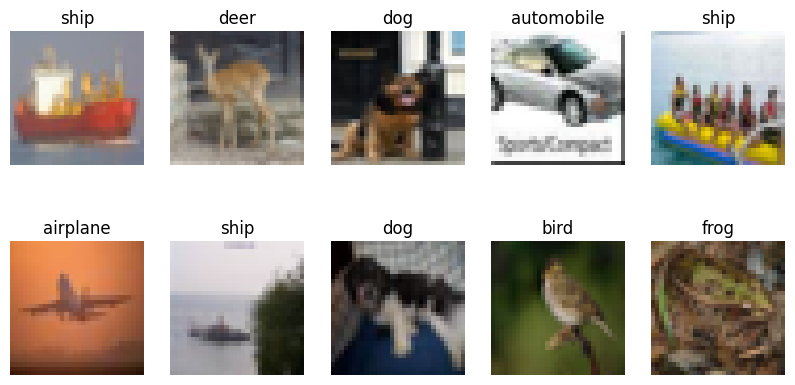

In [52]:
# 데이터 그리기
np.random.seed(100)
random_idx = np.random.randint(50000, size=10)

class_names = ['airplane','automobile', 'bird',' cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_idx):
    ax = plt.subplot(2, 5, i+1)

    ax.imshow(X_train[idx])
    ax.set(title=class_names[y_train[idx]])
    ax.axis('off')

# **2. 데이터 전처리**

## **1) Scaling**

In [53]:
# Scaling 평균, 표준편차 계산
x_mean = np.mean(X_train, axis=(0,1,2))         # 각 채널의 평균 계산
x_std = np.std(X_train, axis=(0,1,2))
print(x_mean)
print(x_std)

[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]


In [54]:
# 표준화(Standardization)
X_train = (X_train-x_mean) / x_std
X_test = (X_test-x_mean) / x_std

## **2) 데이터 분할**

In [55]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

print(f'X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}')

X_train=(35000, 32, 32, 3), X_val=(15000, 32, 32, 3), X_test=(10000, 32, 32, 3), y_train=(35000,), y_val=(15000,), y_test=(10000,)


# **3. 모델 설정**

## ***! Note 전이학습(Transfer Learning)***
[Tensorflow 공식 사이트](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)
1. fc layer(fully connected layer)만 바꾼다.
2. 아랫부분 + fc layer 바꾼다.
3. 전체 바꾼다.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

## **1) 모델 불러오기**

### **VGG16**

In [57]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet',input_shape=(32,32,3),include_top=False)       # include_top : fully connected layer까지 쓰겠니?

In [58]:
# VGG model의 layer 확인하기
vgg16.layers

In [27]:
# 학습 여부 결정
for layer in vgg16.layers[:-4]:
    layer.trainable = False                 # trainable 하지 않겠다(=가중치를 업데이트 하지 않겠다). 뒤에 4개만 재학습 하겠다.

### **ResNet101V2**

In [25]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

resnet101_v2 = ResNet101V2(weights='imagenet',input_shape=(32,32,3),include_top=False)       # include_top : fully connected layer까지 쓰겠니?

171317808/171317808 [==============================] - 10s 0us/step


In [26]:
# ResNet50V2 model의 layer 확인하기
len(resnet101_v2.layers)

377

In [19]:
# 학습 여부 결정
# for layer in resnet50_v2.layers[:-50]:
#     layer.trainable = False

## **2) 모델 설정하기**

### **ResNet**

In [38]:
model = Sequential()

model.add( resnet101_v2 )                              # 모델을 '얼린다'라고 한다.
model.add( Flatten() )
model.add( Dense(32, activation='relu') )
model.add( Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 32)                65568     
                                                                 
 dense_21 (Dense)            (None, 10)                330       
                                                                 
Total params: 42,692,458
Trainable params: 42,594,794
Non-trainable params: 97,664
_________________________________________________________________


In [39]:
# 모델 환경 설정하기(loss, optimizer, metrics 설정)
from tensorflow.keras.optimizers import Adam  ## 가장 많이 쓰이는 learning_rate = 0.0001, 0.0003, ....

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=3e-4),metrics=['accuracy'])

### **VGG16**

In [59]:
model_vgg = Sequential()

model_vgg.add( vgg16 )                              # 모델을 '얼린다'라고 한다.
model_vgg.add( Flatten() )
model_vgg.add( Dense(32, activation='relu') )
model_vgg.add( Dense(10, activation='softmax'))

model_vgg.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 32)                16416     
                                                                 
 dense_27 (Dense)            (None, 10)                330       
                                                                 
Total params: 14,731,434
Trainable params: 14,731,434
Non-trainable params: 0
_________________________________________________________________


In [60]:
# 모델 환경 설정하기(loss, optimizer, metrics 설정)
from tensorflow.keras.optimizers import Adam  ## 가장 많이 쓰이는 learning_rate = 0.0001, 0.0003, ....

model_vgg.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=3e-4),metrics=['accuracy'])

# **4. 모델 학습 및 성능평가**

## **1) ResNet**

In [40]:
from keras.callbacks import EarlyStopping

# 학습 중단 설정
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# 모델 학습
model_fit = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=200,batch_size=128)

Epoch 1/200
274/274 [==============================] - 28s 80ms/step - loss: 0.2775 - accuracy: 0.9320 - val_loss: 0.8733 - val_accuracy: 0.7753
Epoch 2/200
274/274 [==============================] - 21s 77ms/step - loss: 0.1378 - accuracy: 0.9596 - val_loss: 0.9224 - val_accuracy: 0.7767
Epoch 3/200
274/274 [==============================] - 30s 111ms/step - loss: 0.1259 - accuracy: 0.9618 - val_loss: 0.9561 - val_accuracy: 0.7772
Epoch 4/200
274/274 [==============================] - 21s 76ms/step - loss: 0.1083 - accuracy: 0.9679 - val_loss: 0.9593 - val_accuracy: 0.7785
Epoch 5/200
274/274 [==============================] - 21s 76ms/step - loss: 0.0871 - accuracy: 0.9738 - val_loss: 1.0313 - val_accuracy: 0.7816
Epoch 6/200
274/274 [==============================] - 21s 75ms/step - loss: 0.0824 - accuracy: 0.9752 - val_loss: 1.0149 - val_accuracy: 0.7784
Epoch 7/200
274/274 [==============================] - 21s 77ms/step - loss: 0.0843 - accuracy: 0.9733 - val_loss: 0.9790 - val_a

KeyboardInterrupt: 

In [41]:
# 성능 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 5s 17ms/step - loss: 1.2264 - accuracy: 0.7864
Test accuracy: 0.7864000201225281


## **2)VGG16**

In [61]:
from keras.callbacks import EarlyStopping

# 학습 중단 설정
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# 모델 학습
model_vgg_fit = model_vgg.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=200,batch_size=128)

Epoch 1/200
274/274 [==============================] - 16s 54ms/step - loss: 1.2350 - accuracy: 0.5565 - val_loss: 0.7357 - val_accuracy: 0.7520
Epoch 2/200
274/274 [==============================] - 13s 48ms/step - loss: 0.6253 - accuracy: 0.7912 - val_loss: 0.5612 - val_accuracy: 0.8115
Epoch 3/200
274/274 [==============================] - 15s 54ms/step - loss: 0.4392 - accuracy: 0.8527 - val_loss: 0.5201 - val_accuracy: 0.8276
Epoch 4/200
274/274 [==============================] - 13s 47ms/step - loss: 0.3269 - accuracy: 0.8882 - val_loss: 0.4992 - val_accuracy: 0.8377
Epoch 5/200
274/274 [==============================] - 14s 52ms/step - loss: 0.2378 - accuracy: 0.9210 - val_loss: 0.5113 - val_accuracy: 0.8457
Epoch 6/200
274/274 [==============================] - 14s 52ms/step - loss: 0.1651 - accuracy: 0.9449 - val_loss: 0.5390 - val_accuracy: 0.8409
Epoch 7/200
274/274 [==============================] - 14s 50ms/step - loss: 0.1468 - accuracy: 0.9513 - val_loss: 0.5779 - val_ac

274/274 [==============================] - 13s 47ms/step - loss: 0.0314 - accuracy: 0.9917 - val_loss: 0.9687 - val_accuracy: 0.8439
Epoch 58/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0153 - accuracy: 0.9960 - val_loss: 1.0897 - val_accuracy: 0.8444
Epoch 59/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0275 - accuracy: 0.9926 - val_loss: 1.0312 - val_accuracy: 0.8463
Epoch 60/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0179 - accuracy: 0.9950 - val_loss: 1.1378 - val_accuracy: 0.8426
Epoch 61/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 1.0669 - val_accuracy: 0.8447
Epoch 62/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 1.1607 - val_accuracy: 0.8375
Epoch 63/200
274/274 [==============================] - 13s 47ms/step - loss: 0.0302 - accuracy: 0.9919 - val_loss: 1.0635 - val_accuracy

274/274 [==============================] - 13s 46ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.3129 - val_accuracy: 0.8552
Epoch 114/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0179 - accuracy: 0.9954 - val_loss: 0.9817 - val_accuracy: 0.8358
Epoch 115/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0287 - accuracy: 0.9927 - val_loss: 1.1048 - val_accuracy: 0.8530
Epoch 116/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 1.1288 - val_accuracy: 0.8434
Epoch 117/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.9967 - val_accuracy: 0.8491
Epoch 118/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 0.9727 - val_accuracy: 0.8368
Epoch 119/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 1.1378 - val_ac

Epoch 169/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0138 - accuracy: 0.9973 - val_loss: 1.3700 - val_accuracy: 0.8471
Epoch 170/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 1.2674 - val_accuracy: 0.8454
Epoch 171/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 1.7747 - val_accuracy: 0.8358
Epoch 172/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 1.2079 - val_accuracy: 0.8426
Epoch 173/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 1.2464 - val_accuracy: 0.8343
Epoch 174/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0122 - accuracy: 0.9971 - val_loss: 1.3091 - val_accuracy: 0.8464
Epoch 175/200
274/274 [==============================] - 13s 46ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 1

In [62]:
# 성능 평가
test_loss, test_acc = model_vgg.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 1.3372 - accuracy: 0.8401
Test accuracy: 0.8400999903678894


# **5. 결론**

* ResNet은 과적합이 심한 반면 상대적으로 vgg16이 더 성능이 좋은 것으로 나온다.